# Assignment 3

This assignment has one main part:

**PCA** : In this part the goal is to implement the dimensionality reduction technique *Principal Component Analysis (PCA)* to a very high dimensional data and apply visualization. Note that you are not allowed to use the built-in PCA API provided by the sklearn library. Instead you will be implementing from the scratch. Use the data in data/train.csv for generating the PCA. See the detailed intructions below.
    

For this task we use the  MovieLens dataset. The data is in train.csv.
   

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm

# Part-1a: Convert data to user-movie rating matrix (10 points)
    - Read the train.csv file and movies.dat file and use user_id and movie_id to create user-movie rating matrix


In [2]:
def readMovieData():
    """Read movies.dat and extract movie_id, title, and genres."""
    movies = pd.read_csv('movies.dat', delimiter='::', engine='python', 
                         names=['movie_id', 'title', 'genres'], encoding='ISO-8859-1')
    return movies

In [3]:
def readMovieRatingData():
    train_path = "train.csv"
    ratings_df = pd.read_csv(train_path)
    
    user_movie_matrix = ratings_df.pivot(index="user_id", columns="movie_id", values="rating").fillna(0)
    
    all_users = range(1, 6041)  
    all_movies = range(1, 3953)  
    
    user_movie_matrix = user_movie_matrix.reindex(index=all_users, columns=all_movies, fill_value=0)
    
    return user_movie_matrix


In [4]:
movie_data = readMovieData()
print(movie_data.head()) 

   movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [5]:
movie_data.shape

(3883, 3)

`movie_data` should have the shape 3883x3

In [6]:
movie_ratings = readMovieRatingData()
movie_ratings.shape


(6040, 3952)

movie_ratings should have the shape 6040 (users) x 3952 (movies)

Check if the specific user and movie exists 


In [7]:
user_id_check = 5222
movie_id_check = 3635
#3
if user_id_check in movie_ratings.index and movie_id_check in movie_ratings.columns:
    rating = movie_ratings.at[user_id_check, movie_id_check]  
    print(f"User ID: {user_id_check}, Movie ID: {movie_id_check} has rating: {rating}")
else:
    print(f"Rating not found for User ID: {user_id_check}, Movie ID: {movie_id_check}")

User ID: 5222, Movie ID: 3635 has rating: 3.0


In [8]:
movie_ids_in_data = movie_data['movie_id'].tolist()
filtered_movie_ratings = movie_ratings[movie_ids_in_data]
print(filtered_movie_ratings.shape)

(6040, 3883)


In [9]:
movie_ratings = filtered_movie_ratings
movie_ratings.shape

(6040, 3883)

## We are going to compute PCA for movies so transpose the matrix using X=readMovieRatingData().T


# Part-1b: Preprocessing  (10 points)
Before implementing PCA you are required to perform some preprocessing steps:
1. Mean normalization: Replace each feature/attribute, $x_{ji}$ with $x_j - \mu_j$, In other words, determine the mean of each feature set, and then for each feature subtract the mean from the value, so we re-scale the mean to be 0 
2. Feature scaling: If features have very different scales then scale make them comparable by altering the scale, so they all have a comparable range of values e.g. $x_{ji}$ is set to $(x_j - \mu_j) / s_j$  Where $s_j$ is some measure of the range, so could be  $\max(x_j) - \min(x_j)$ or Standard deviation $stddev(x_j)$.

In [10]:
def normScale(X):   
    # Return the normalized data and the mean and standard deviation used for normalization
    # Hint: You can use the np.mean and np.std functions
    # Normalize the data to have zero mean and unit variance
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    std_X = np.where(std_X == 0, 1, std_X)
    X_norm = (X - mean_X) / std_X
    return X_norm

X = movie_ratings
X = normScale(X)

In [11]:
X.shape

(6040, 3883)

In [12]:
user_id_check = 5222
movie_id_check = 3635
#4
if user_id_check in X.index and movie_id_check in X.columns:
    rating = X.at[user_id_check, movie_id_check]  
    print(f"User ID: {user_id_check}, Movie ID: {movie_id_check} has rating: {rating}")
else:
    print(f"Rating not found for User ID: {user_id_check}, Movie ID: {movie_id_check}")


User ID: 5222, Movie ID: 3635 has rating: 3.027057879031003


# Part-2: Covariance matrix  (15 points)
Now the preprocessing is finished. Next, as explained in the lecture, you need to compute the covariance matrix https://en.wikipedia.org/wiki/Covariance_matrix. Given $n \times m$ $n$ rows and $m$ columns matrix, a covariance matrix is an $m \times m$ matrix given as below (sigma)
$\Sigma = \frac{1}{m}\sum{\left(x^{i}\right)\times \left(x^{i}\right)^{T}}$
You may use the "numpy.cov" function in numpy library 

In [13]:
# Compute X to covariance matrix cov_matrix.
#cov_matrix = np.cov(X)
cov_matrix = np.cov(X)


The cov_matrix should have shape 6040x6040

In [14]:
print("Movie Ratings Shape:", movie_ratings.shape) 
print("Movie Data Shape:", movie_data.shape)
print("Covariance Matrix Shape:", cov_matrix.shape) 

Movie Ratings Shape: (6040, 3883)
Movie Data Shape: (3883, 3)
Covariance Matrix Shape: (6040, 6040)


In [15]:
cov_matrix.shape

(6040, 6040)

Check for NaN or infinite values in the covariance matrix


In [16]:
if np.any(np.isnan(cov_matrix)) or np.any(np.isinf(cov_matrix)):
    print("Covariance matrix contains NaN or infinite values")
    cov_matrix = np.nan_to_num(cov_matrix, nan=0.0, posinf=1e10, neginf=-1e10)


In [17]:
cov_matrix.shape

(6040, 6040)

# Instructions for part 3, 4, and 5
- getSVD() function is expected to return 3 values. For example: ```U, S, V = getSVD(cov_matrix)```
- You can follow the skeleton below to have an idea on how the autograder's test calls your functions:
```
U, S, V = getSVD(cov_matrix)
z = getKComponents(U, X, k)
ratio = getVarianceRatio(z, U, X, k)
```
- Using the built-in PCA implementation in sklearn, the approximate X matrix can be obtained by function ```inverse_transform```

# Part-3: SVD computation  (10 points)
Now compute the SVD on the covariance matrix $SVD(\Sigma)$. You may use the svd implementation in numpy.linalg.svd

In [18]:
def getSVD(cov_matrix):
    #TODO user np.linalg.svd here
    U, S, V = np.linalg.svd(cov_matrix, full_matrices=False)
    return U, S, V


In [19]:
U, S, V = getSVD(cov_matrix)

In [20]:
U.shape, S.shape, V.shape

((6040, 6040), (6040,), (6040, 6040))

# Part-4: Compute PCA matrix (K dimensional)  (10 points)
Now select the first $k$ columns from the matrix $U$ and multiply with $X$ to get $k$ dimensional representation.

In [21]:
def getKComponents(U, X, K):
    # implement matrix multiplication of first k columns of U * X
    U = U[:, :K]
    UX = np.dot(U.T,X)
    print(UX.shape)
    return UX


In [22]:
X.shape

(6040, 3883)

In [23]:
print(U.shape)
print( U[:, :2].shape)

(6040, 6040)
(6040, 2)


In [24]:
z = getKComponents(U, X, 2)
z = z.T

(2, 3883)


In [25]:
z.shape

(3883, 2)

# Part-5: Compute Reconstruction Error  (10 points)
Implement a function to compute the variance ratio (from reconstruction error)

In [26]:
def getVarianceRatio(Z, U, X, K):


    U_reduce = U[:, :K] 
    X_approx = np.dot(Z, U_reduce.T)  
    X = X.T
    print("X",X.shape)
    print("X_approx",X_approx.shape)
    assert X.shape == X_approx.shape, f"Shape mismatch: X {X.shape}, X_approx {X_approx.shape}"
    if np.any(np.isnan(X)) or np.any(np.isnan(X_approx)):
       print("Warning: NaN values detected in X or X_approx.")
       return np.nan  
    reconstruction_error = np.linalg.norm(X - X_approx, 'fro') / np.linalg.norm(X, 'fro')
    return reconstruction_error


In [27]:
U.shape

(6040, 6040)

In [28]:
z.shape

(3883, 2)

In [29]:
ratio = getVarianceRatio(z, U, X, 2)

X (3883, 6040)
X_approx (3883, 6040)


In [30]:
ratio

np.float64(0.9675126966495352)

In [31]:
print("Variance Ratio:", ratio)

Variance Ratio: 0.9675126966495352


# Compare the variance ration to the built-in PCA implementation in sklearn https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html (5 points)

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(X)


In [33]:
X_approx_pca = pca.inverse_transform(z_pca)

# TODO: Compute the reconstruction error

reconstruction_error = np.linalg.norm(X - X_approx_pca, 'fro') / np.linalg.norm(X, 'fro')


In [34]:
print("Reconstruction Error (sklearn PCA):", reconstruction_error)

Reconstruction Error (sklearn PCA): 0.9610808753983722


# Part-6: Scatter plot 2-dimensional PCA  (10 points)
Using matplotlib plot the 2-dimensional scatter plot of the first 2 compoenents with y (movie genre from movies.dat file) as labels. Remember you are plotting movies in dimensions so you can label them with movie generes.

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

def plotFunction(PC, movie_data):
    if PC.shape[1] != 2:
        raise ValueError("PC should have exactly 2 columns for 2D plotting.")
    
    unique_genres = list(set('|'.join(movie_data['genres']).split('|')))
    
    custom_palette = ["#1f77b4", "#9467bd", "#2ca02c", "#d62728", "#ff7f0e", "#8c564b", 
                        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#1f77b4", "#9467bd", 
                        "#2ca02c", "#d62728", "#ff7f0e", "#8c564b", "#f7b6d0", "#50bf6b"]

    
    genre_to_color = {genre: custom_palette[i % len(custom_palette)] for i, genre in enumerate(unique_genres)}
    
    movie_data['first_genre'] = movie_data['genres'].apply(lambda g: g.split('|')[0] if isinstance(g, str) else 'Unknown')
    colors = [genre_to_color.get(genre, "gray") for genre in movie_data['first_genre']]

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(PC[:, 0], PC[:, 1], c=colors, alpha=0.7, edgecolors='k')

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("2D PCA - Movie Genre Coloring")

    plt.xlim(-20, 40)
    plt.ylim(-30, 30)

    handles = [mlines.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=genre_to_color[genre]) 
               for genre in unique_genres]
    plt.legend(handles, unique_genres, loc='best', title="Genres", fontsize='small')

    plt.grid(True)
    plt.show()


In [36]:
print("z.shape:", z.shape)
print("movie_data.shape:", movie_data.shape) 

z.shape: (3883, 2)
movie_data.shape: (3883, 3)


In [37]:
movie_data.head(4)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama


In [38]:
print(z[:5,:2]) 

[[28.14668111 16.84948672]
 [34.12638066  6.47890254]
 [25.65410062  1.18433457]
 [14.85014549  3.35801452]
 [23.19620551  0.73785184]]


In [39]:
movie_data.shape

(3883, 3)

In [40]:
movie_data = movie_data.iloc[:len(z)]  
movie_data.shape

(3883, 3)

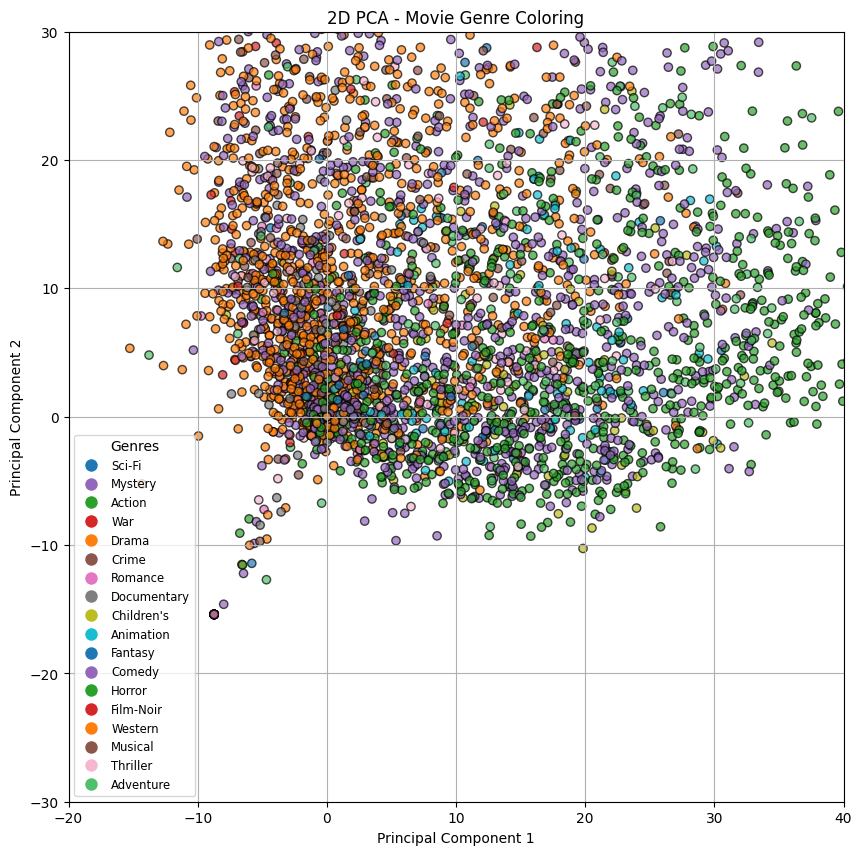

In [41]:
plotFunction(z, movie_data)

# Part-7 Find best $K$  (10 points)
Find the minimum value of $K$ with which the ratio between averaged squared projection error with total variation in data is less than 1% in other words we retain 90% of the variance. You can achieve this by repeating getKComponents with $K=1$ until the variance ratio is <= 1%.

In [ ]:
def findBestK(initial, step, U, X):
    K_min = initial  
    reconstruction_error = 1  

    while reconstruction_error > 0.1:  
        ztest = getKComponents(U, X, K_min)

        reconstruction_error = getVarianceRatio(ztest.T, U, X, K_min)
        
        print(f"K={K_min}, Reconstruction Error={reconstruction_error}")
        
        if reconstruction_error <= 0.1:
            break  
        
        K_min += step  
    
    return K_min


In [ ]:
k_best = findBestK(1, 20, U, X)

(1, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=1, Reconstruction Error=0.9823025037996236
(21, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=21, Reconstruction Error=0.8993660096591584
(41, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=41, Reconstruction Error=0.871262044982434
(61, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=61, Reconstruction Error=0.8502700966435754
(81, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=81, Reconstruction Error=0.832084660965229
(101, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=101, Reconstruction Error=0.815778045321625
(121, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=121, Reconstruction Error=0.800770810917512
(141, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=141, Reconstruction Error=0.7867254990067118
(161, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=161, Reconstruction Error=0.7735359056179858
(181, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=181, Reconstruction Error=0.7610137826363919
(201, 3883)
X (3883, 6040)
X_approx (3883, 6040)
K=201, 

KeyboardInterrupt: 

In [ ]:
k_best

3581

# Part-8: TSNE visualization (10 points)
Finally, having found an optimal $K$ use these components as an input data to another dimensionality reduction method called tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) and reduce it to 2 dimensions.

In [44]:
from sklearn.manifold import TSNE
tsne_pca_results = None

In [45]:
def apply_tsne_to_pca(pca_components, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state)
    tsne_results = tsne.fit_transform(pca_components)  
    return tsne_results

In [47]:
pca_components = z
tsne_pca_results = apply_tsne_to_pca(pca_components, n_components=2)

Finally, scatter plot the components given by the tSNE using matplotlib compare it to the earlier scatter plot.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plotFunction_tsne(PC, movie_data):
    if PC.shape[1] != 2:
        raise ValueError("PC should have exactly 2 columns for 2D plotting.")
    
    unique_genres = list(set('|'.join(movie_data['genres']).split('|')))
    
    custom_palette = ["#1f77b4", "#9467bd", "#2ca02c", "#d62728", "#ff7f0e", "#8c564b", 
                      "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#f7b6d0", "#50bf6b"]

    genre_to_color = {genre: custom_palette[i % len(custom_palette)] for i, genre in enumerate(unique_genres)}

    movie_data['first_genre'] = movie_data['genres'].apply(lambda g: g.split('|')[0] if isinstance(g, str) else 'Unknown')
    colors = [genre_to_color.get(genre, "gray") for genre in movie_data['first_genre']]

    plt.figure(figsize=(10, 10))

    scatter = plt.scatter(PC[:, 0], PC[:, 1], c=colors, alpha=0.6, edgecolors='w', s=60)  

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("2D PCA - Movie Genre Coloring")

    handles = [mlines.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=genre_to_color[genre]) 
               for genre in unique_genres]
    plt.legend(handles, unique_genres, loc='upper right', title="Genres", fontsize='small')

    plt.grid(False)  
    plt.show()


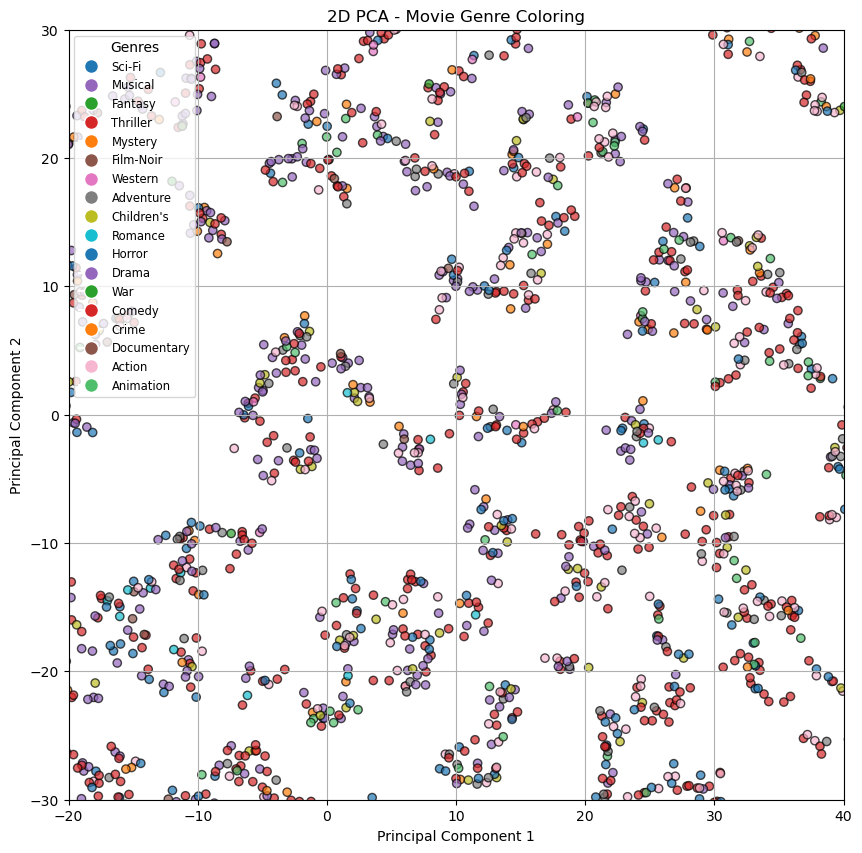

In [ ]:
# Scatter plot the 2-dimensional tsne compoents with target as labels
plotFunction(tsne_pca_results, movie_data)

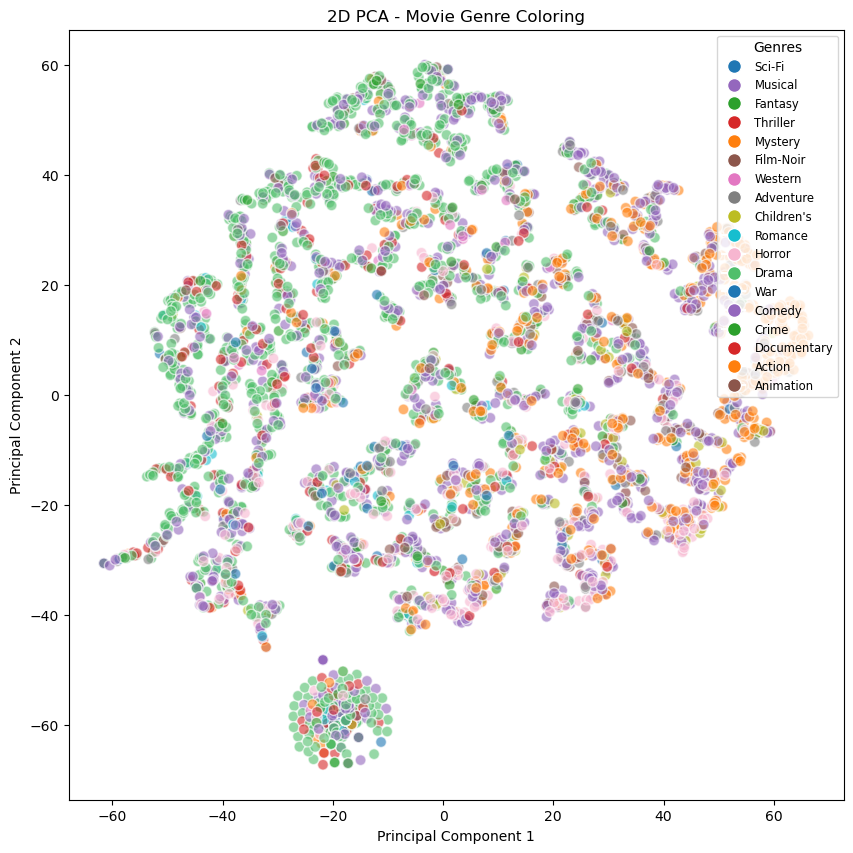

In [ ]:
plotFunction_tsne(tsne_pca_results, movie_data)